In [1]:
import pickle 
import numpy as np 
import pandas as pd
import networkx as nx
from tqdm import tqdm
import time
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations
import community
import collections

from src.utils.data_utils import *
from src.utils.general_utils import *
from src.utils.mapping import *
from src.utils.langue import *

In [2]:
movie_path = 'data/Movie.pkl'
actors_path = 'data/Actor.pkl'

with open(movie_path, 'rb') as file:
    Movie = pickle.load(file)
Movie = Movie.reset_index()
with open(actors_path, 'rb') as file:
    Actor = pickle.load(file)

C:\Users\Thibault Schiesser\AppData\Local\Temp\ipykernel_23900\2668311966.py:5: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  Movie = pickle.load(file)


In [3]:
nombre_entrees = Movie.Movie_languages.str.contains(',', na=False).sum()

In [4]:
nombre_entrees

np.int64(7888)

In [5]:
Movie.Movie_languages.shape

(61042,)

In [6]:
a = create_actor_language_dataset(Movie, Actor, 5)

We lose 13.58% of the dataset of movies with this operation.


In [7]:
presence = create_cross_language(a)
compte = create_cross_language_count(a)

regardons si nous avons la même proportion de language de langue pour chaque nb_movie <br> on considère 4 groupes :
- 1 <= nb_film <= 2
- 3 <= nb_film <= 5
- 5 < nb_movie <= 10
- nb_movie > 10
 
<br> h0 : la proportion des langues est la même dans chaque groupe

In [25]:
a["nb_movie"]= a.sum(axis=1)

In [51]:
dict_group = {}
group1 = a[a["nb_movie"]<3]
dict_group[1] = group1
group2 = a[(a["nb_movie"]>2) & (a["nb_movie"]<6)]
dict_group[2] = group2
group3 = a[(a["nb_movie"]<11) & (a["nb_movie"]>5)]
dict_group[3] = group3
group4 = a[a["nb_movie"]>10]
dict_group[4] = group4
print(group1.shape[0] + group2.shape[0] + group3.shape[0] + group4.shape[0] == a.shape[0])

True


In [78]:
nb_group = 4
dict_total = {}

for g in range(1, nb_group + 1):
    group = dict_group[g]
    total_movie = group.nb_movie.sum()
    
    for i in group.columns:
        if i != "nb_movie":
            ratio = float(group[i].sum() / total_movie)
    
            if i in dict_total:
                dict_total[i].append(ratio)
            else:
                dict_total[i] = [ratio]

print(dict_total)

{'English Language': [0.7979323866674588, 0.8204991087344029, 0.8393774903274239, 0.8215969535783365], 'Hindi Language': [0.028073198265106056, 0.042572786690433746, 0.06406998902812265, 0.1378949065119278], 'Spanish Language': [0.060543045570673165, 0.0421865715983363, 0.021568400993243635, 0.007464941972920696], 'Italian Language': [0.04310498484938506, 0.03933452168746286, 0.03049026967719582, 0.01606826241134752], 'French Language': [0.07034638464737686, 0.05540701128936423, 0.044493849974013976, 0.01697493552546744]}


In [69]:
from scipy.stats import chi2_contingency

In [79]:
df = pd.DataFrame(dict_total, index=[1,2,3,4])

In [88]:
chi2, p_value, dof, expected = chi2_contingency(df)

In [89]:
# Résultats
print("Statistique du Chi-2 :", chi2)
print("P-value :", p_value)
print("Degrés de liberté :", dof)
print("Tableau attendu théorique :\n", expected)

# Conclusion
if p_value < 0.05:
    print("Les distributions sont statistiquement différentes (p < 0.05).")
else:
    print("Aucune différence significative entre les distributions (p >= 0.05).")

Statistique du Chi-2 : 0.20116474096698686
P-value : 0.9999999986805574
Degrés de liberté : 12
Tableau attendu théorique :
 [[0.81985148 0.06815272 0.03294074 0.03224951 0.04680555]
 [0.81985148 0.06815272 0.03294074 0.03224951 0.04680555]
 [0.81985148 0.06815272 0.03294074 0.03224951 0.04680555]
 [0.81985148 0.06815272 0.03294074 0.03224951 0.04680555]]
Aucune différence significative entre les distributions (p >= 0.05).


balance dataset ???

plot :

In [91]:
import seaborn.objects as so

In [93]:
 expected[0]

array([0.81985148, 0.06815272, 0.03294074, 0.03224951, 0.04680555])

In [98]:
df.iloc[0,:].values

array([0.79793239, 0.0280732 , 0.06054305, 0.04310498, 0.07034638])

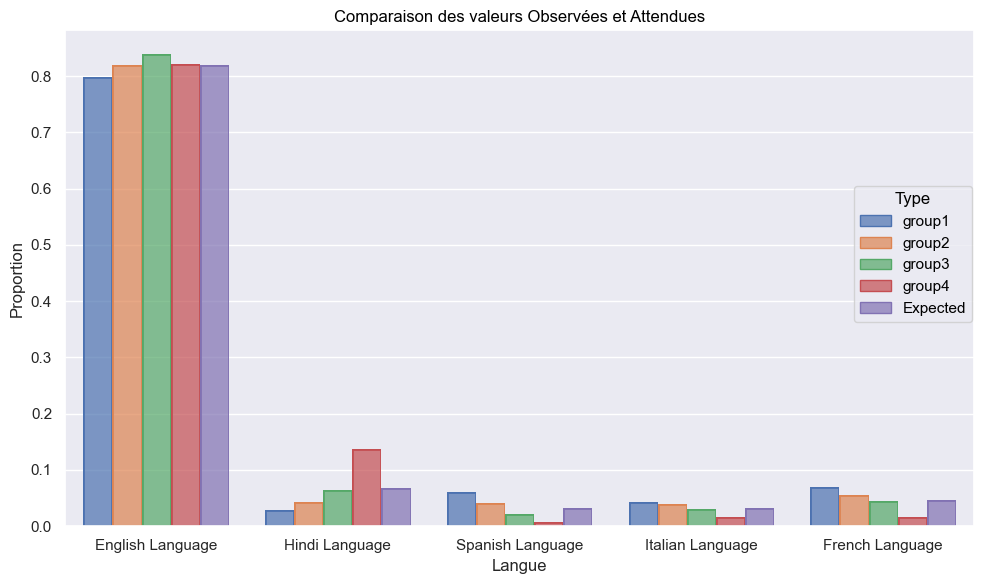

In [102]:
languages = ['English Language', 'Hindi Language', 'Spanish Language', 'Italian Language', 'French Language']
expected_means = pd.DataFrame({
    'Language': languages,
    'Value':  expected[0],
    'Type': 'Expected'
})
g1 = pd.DataFrame({
    'Language': languages,
    'Value': df.iloc[0,:].values,
    'Type': 'group1'
})
g2 = pd.DataFrame({
    'Language': languages,
    'Value': df.iloc[1,:].values,
    'Type': 'group2'
})
g3 = pd.DataFrame({
    'Language': languages,
    'Value': df.iloc[2,:].values,
    'Type': 'group3'
})
g4 = pd.DataFrame({
    'Language': languages,
    'Value': df.iloc[3,:].values,
    'Type': 'group4'
})
combined_df = pd.concat([g1,g2,g3,g4, expected_means])
p = (
    so.Plot(combined_df, x="Language", y="Value", color="Type")  # Type pour la couleur
    .add(so.Bar(), so.Dodge())  # Barres avec un décalage pour les deux types
    .layout(size=(10, 6))  # Taille du graphique
    .label(title="Comparaison des valeurs Observées et Attendues", 
           x="Langue", 
           y="Proportion")
)

p.show()